<a href="https://colab.research.google.com/github/saecula/notebooks/blob/main/markets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd;

In [3]:
df = pd.read_csv('/content/drive/Othercomputers/My MacBook Pro/Documents/manifold/markets/markets_og.csv');

In [4]:
pd.options.display.max_columns = None
print(df.head())

                     id                     creatorId creatorUsername  \
0  EWKoMh6J9Gzb1CrQd21N  HBlWMFF8XkcatdnIfNt0RPoCrXy1           iblue   
1  pISgmVyfKF0YZn6phHZM  HBlWMFF8XkcatdnIfNt0RPoCrXy1           iblue   
2  J1bpRzgkCCrZabmznKJ4  zPHQcxyXADVDAp0Km9ZSYdj2ti03      CquilPromp   
3  syOTAi1MoutyVzp7GMTH  Lo90oBP3atgQe1GtAVeLrAPcixo1      DavidSpies   
4  TL0frhKfAI5oiuhkGaLl  cgrBqe2O3AU4Dnng7Nc9wuJHLKb2            jskf   

   creatorName    createdTime  \
0        iblue  1691245362417   
1        iblue  1691245249757   
2  Cquil Promp  1691245029677   
3  David Spies  1691245017606   
4         jskf  1691245015722   

                                    creatorAvatarUrl      closeTime  \
0  https://firebasestorage.googleapis.com/v0/b/ma...  1691877540000   
1  https://firebasestorage.googleapis.com/v0/b/ma...  1691877540000   
2  https://lh3.googleusercontent.com/a/AAcHTtduBM...  1691348400000   
3  https://lh3.googleusercontent.com/a/AEdFTp4cHz...  2616652740000   
4  http

In [48]:
# format
pd.options.display.float_format = '{:.0f}'.format

df['totalLiquidity'] = pd.to_numeric(df['totalLiquidity'], errors='coerce')
df['volume'] = pd.to_numeric(df['volume'], errors='coerce')
df['pool_yes'] = pd.to_numeric(df['pool_yes'], errors='coerce')
df['pool_no'] = pd.to_numeric(df['pool_yes'], errors='coerce')

print('info', df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52241 entries, 0 to 52240
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     52241 non-null  object        
 1   creatorId              52241 non-null  object        
 2   creatorUsername        52240 non-null  object        
 3   creatorName            52241 non-null  object        
 4   createdTime            52241 non-null  datetime64[ns]
 5   creatorAvatarUrl       52241 non-null  object        
 6   closeTime              52241 non-null  int64         
 7   question               52232 non-null  object        
 8   url                    52241 non-null  object        
 9   probability            52241 non-null  object        
 10  p                      52241 non-null  object        
 11  totalLiquidity         47437 non-null  float64       
 12  outcomeType            52241 non-null  object        
 13  m

In [66]:
# filter

# filtered_df = df[df['field'] == 'value']

january_2023_to_june_2023 = df[(df['createdTime'] >= '2023-01-01') & (df['createdTime'] <= '2023-06-30')]
outcometype_binary = january_2023_to_june_2023[january_2023_to_june_2023['outcomeType'] == 'BINARY']

activity = outcometype_binary[['id', 'totalLiquidity', 'volume', 'pool_yes', 'pool_no']]


print('stats:')
print(activity.describe())

markets = activity[activity['volume'] > 100] # caps at 999?

print('active markets:')
print(markets.describe())

stats:
       totalLiquidity  volume  pool_yes  pool_no
count           24498   14382     24498    24498
mean              319     256      1811     1811
std               564     258      9538     9538
min                50       0         0        0
25%               110      51        86       86
50%               190     161       205      205
75%               330     393       597      597
max             22006     999    329470   329470
active markets:
       totalLiquidity  volume  pool_yes  pool_no
count            8889    8889      8889     8889
mean              225     391       291      291
std               189     245       249      249
min                50     101         0        0
25%               130     185       143      143
50%               190     318       237      237
75%               270     552       378      378
max             10600     999     10441    10441


In [67]:
import matplotlib.pyplot as plt
import datetime

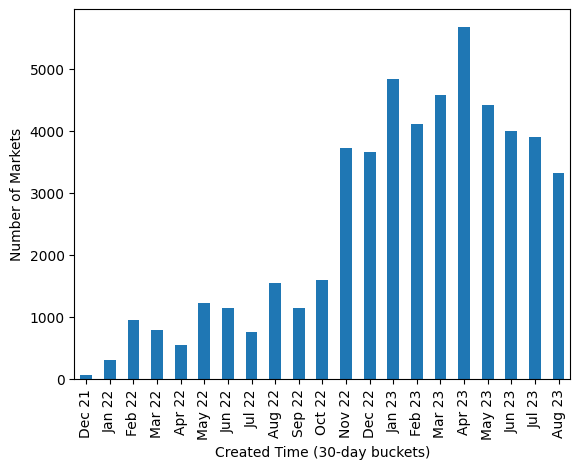

In [15]:
# a date histogram showing markets by createdTime, bucketed in 30-day increments.

df['createdTime'] = pd.to_datetime(df['createdTime'], unit='ms')
df['createdTime_seconds'] = df['createdTime'].apply(lambda x: x.timestamp())
df['createdTime_bucket'] = (df['createdTime_seconds'] // (3600*24*30)).astype(int)

# Create a PeriodIndex for the x-axis to show human-readable month labels
period_index = pd.period_range(start=df['createdTime'].min().normalize(),
                               end=df['createdTime'].max().normalize(),
                               freq='M')

# Plot the data
df.groupby('createdTime_bucket')['id'].count().plot(kind='bar')

# Set the x-axis tick labels
plt.xticks(range(len(period_index)), period_index.to_timestamp().strftime('%b %y'))

plt.xlabel('Created Time (30-day buckets)')
plt.ylabel('Number of Markets')
plt.show()


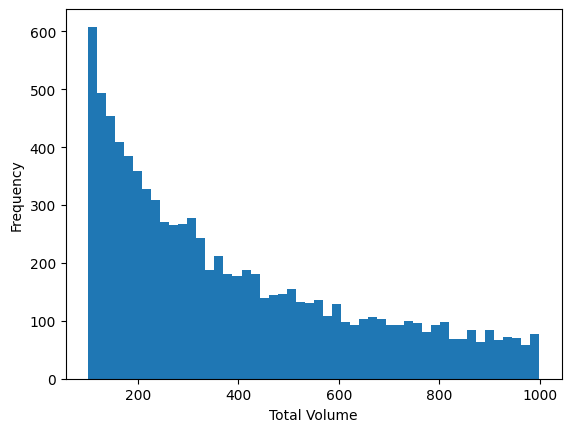

In [59]:
# plot distribution

volume = markets['volume']
plt.hist(volume, bins=50)
plt.xlabel('Total Volume')
plt.ylabel('Frequency')
plt.show()


In [68]:
import json
import os

In [79]:
json_dir = '/content/drive/Othercomputers/My MacBook Pro/Documents/manifold/bets'

market_ids = markets['id'].tolist()

columns_to_include = ['id', 'createdTime', 'userId', 'contractId', 'amount', 'shares', 'outcome', 'visibility', 'isFilled', 'isCancelled', 'isChallenge', 'orderAmount', 'probBefore', 'probAfter']

def load_bets_from_json(file_path, ids):
    with open(file_path, 'r') as f:
        bets_json = json.load(f)

    # print first bet
    print('new file, first bet:')
    print(bets_json[0])

    df_raw = pd.DataFrame(bets_json)

    print(df_raw.columns)

    df_bets = df_raw[columns_to_include]
    df_market_filtered = df_bets[df_bets['contractId'].isin(ids)]
    return df_market_filtered

# load files that end with json and contain string '2023'
bets_dfs = []
for file in os.listdir(json_dir):
    if file.endswith('.json') and '2023' in file:
        file_path = os.path.join(json_dir, file)
        bets_df = load_bets_from_json(file_path, market_ids)
        bets_dfs.append(bets_df)

bets_df = pd.concat(bets_dfs, ignore_index=True)

new file, first bet:
{'id': 'KDkdCh7q3mp9NDHyRCkW', 'fees': {'creatorFee': 0, 'platformFee': 0, 'liquidityFee': 0}, 'fills': [{'amount': 15.368347602283931, 'shares': 31.668056399014972, 'timestamp': 1690854229511, 'matchedBetId': None}], 'isApi': True, 'amount': 15.368347602283931, 'isAnte': False, 'shares': 31.668056399014972, 'userId': 'BhNkw088bMNwIFF2Aq5Gg9NTPzz1', 'outcome': 'YES', 'isFilled': False, 'userName': 'Acceleration', 'limitProb': 0.49, 'probAfter': 0.48999999999999994, 'contractId': 'YBnsUM8iAs3DTyyLqpcZ', 'loanAmount': 0, 'probBefore': 0.48058993432878344, 'visibility': 'public', 'createdTime': 1690854229511, 'isCancelled': True, 'isChallenge': False, 'orderAmount': 100, 'isRedemption': False, 'userUsername': 'acc', 'userAvatarUrl': 'https://firebasestorage.googleapis.com/v0/b/mantic-markets.appspot.com/o/user-images%2FAccelerationBot%2FtGI0YIHNo5.44?alt=media&token=b4b3edf9-839c-4f1f-941e-82b308eedd5e'}
Index(['id', 'fees', 'fills', 'isApi', 'amount', 'isAnte', 'shar

In [80]:
bets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180869 entries, 0 to 180868
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           180869 non-null  object 
 1   createdTime  180869 non-null  int64  
 2   userId       180869 non-null  object 
 3   contractId   180869 non-null  object 
 4   amount       180869 non-null  float64
 5   shares       180869 non-null  float64
 6   outcome      180869 non-null  object 
 7   visibility   180869 non-null  object 
 8   isFilled     160439 non-null  object 
 9   isCancelled  160439 non-null  object 
 10  isChallenge  180869 non-null  bool   
 11  orderAmount  159784 non-null  float64
 12  probBefore   180869 non-null  float64
 13  probAfter    180869 non-null  float64
dtypes: bool(1), float64(5), int64(1), object(7)
memory usage: 18.1+ MB
